<a href="https://colab.research.google.com/github/Kamil11-del/Multi_Class-Flowers-Classification_CNN/blob/main/CNN_multiClass_flowers_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN Flowers Classificaltion:**

**Import Necessary Libraries:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# **DATA PRE-PROCESSING:**

**Labling the Data To prepare:**

In [2]:
data_path ='/content/drive/MyDrive/flower_images'

# Use list comprehension for efficient file path and label collection
filepath = [os.path.join(data_path, fold, file) for fold in os.listdir(data_path) for file in os.listdir(os.path.join(data_path, fold))]
label = [fold for fold in os.listdir(data_path) for _ in os.listdir(os.path.join(data_path, fold))]

# Concat data paths with labels
df = pd.DataFrame({'filepath': filepath, 'labels': label})

# Display the dataframe
print(df.head())
df

                                            filepath labels
0  /content/drive/MyDrive/flower_images/Lotus/0b6...  Lotus
1  /content/drive/MyDrive/flower_images/Lotus/04f...  Lotus
2  /content/drive/MyDrive/flower_images/Lotus/083...  Lotus
3  /content/drive/MyDrive/flower_images/Lotus/063...  Lotus
4  /content/drive/MyDrive/flower_images/Lotus/03f...  Lotus


,filepath,labels
0,/content/drive/MyDrive/flower_images/Lotus/0b6...,Lotus
1,/content/drive/MyDrive/flower_images/Lotus/04f...,Lotus
2,/content/drive/MyDrive/flower_images/Lotus/083...,Lotus
3,/content/drive/MyDrive/flower_images/Lotus/063...,Lotus
4,/content/drive/MyDrive/flower_images/Lotus/03f...,Lotus
...,...,...
4995,/content/drive/MyDrive/flower_images/Sunflower...,Sunflower
4996,/content/drive/MyDrive/flower_images/Sunflower...,Sunflower
4997,/content/drive/MyDrive/flower_images/Sunflower...,Sunflower
4998,/content/drive/MyDrive/flower_images/Sunflower...,Sunflower


In [3]:
print("Shape of the dataset: ", df.shape)
print("_______________________________________")
print("Number of null values: ")
print(df.isnull().sum())
print("_______________________________________")
print("Number of unique values: ")
print(df.nunique())

print("---------------------------------------")
print("Number of images per category : ")
print(df.labels.value_counts())

Shape of the dataset:  (5000, 2)
_______________________________________
Number of null values: 
filepath    0
labels      0
dtype: int64
_______________________________________
Number of unique values: 
filepath    5000
labels         5
dtype: int64
---------------------------------------
Number of images per category : 
labels
Lotus        1000
Lilly        1000
Orchid       1000
Tulip        1000
Sunflower    1000
Name: count, dtype: int64


**Spliting The DataSet:**
(into Train, Validate, Test)

In [4]:
train_set,dummy_set = train_test_split(df, train_size=0.8, random_state=42)
val_set,test_set = train_test_split(dummy_set, test_size=0.5, random_state=42)
print("---------------------------------------")
print("Shape of the train set: ", train_set.shape)
print("Shape of the validation set: ", val_set.shape)
print("Shape of the test set: ", test_set.shape)

---------------------------------------
Shape of the train set:  (4000, 2)
Shape of the validation set:  (500, 2)
Shape of the test set:  (500, 2)


**Showing Some Samples from dataset**

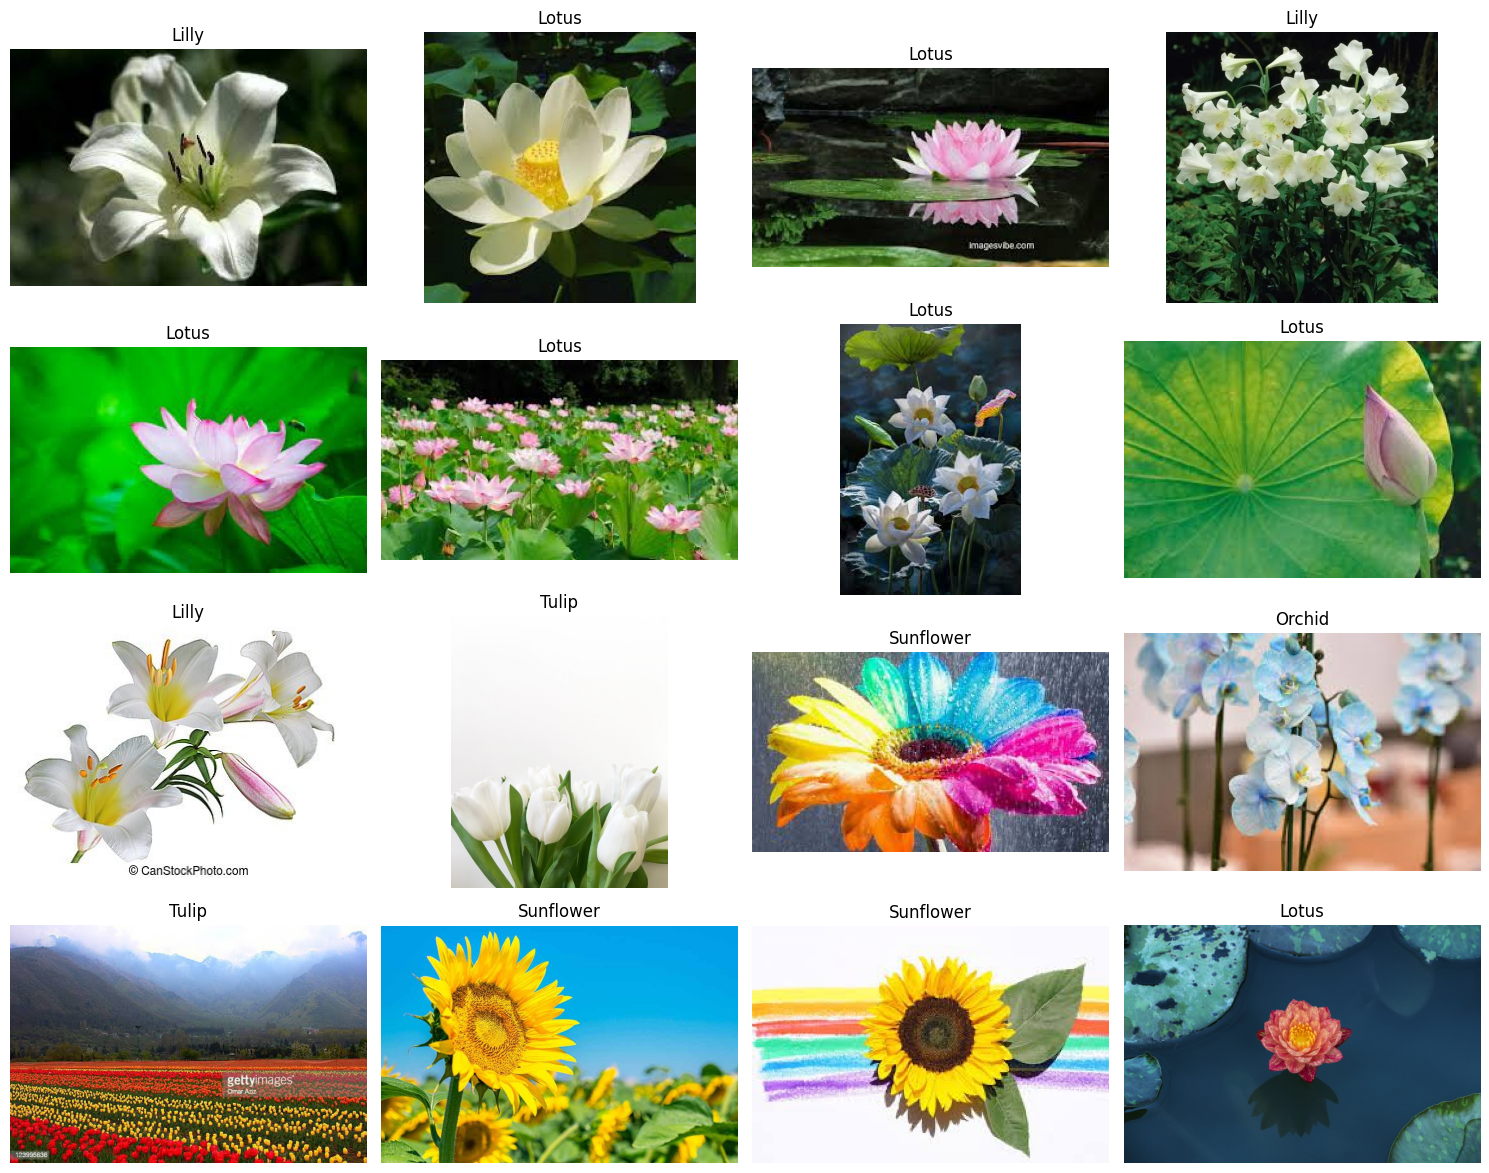

In [ ]:
# Assuming test_df is already defined
plt.figure(figsize=(15,12))

# Sample 16 images directly and reset the index in one step
sampled_images = test_set.sample(n=16, random_state=42).reset_index()

for i, row in sampled_images.iterrows():
    plt.subplot(4, 4, i + 1)
    image = Image.open(row['filepath'])
    plt.imshow(image)
    plt.title(row['labels'])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
image_size = (224, 224)
batch_size = 32
# Define common parameters
common_params = {
    'target_size': image_size,
    'class_mode': 'categorical',
    'color_mode': 'rgb',
    'batch_size': batch_size
}

# Create ImageDataGenerators
tr_gen = ImageDataGenerator(
    rescale=1./255,              # Rescale pixel values to [0, 1]
    rotation_range=40,         # Rotate images by up to 40 degrees
    width_shift_range=0.2,     # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Shift images vertically by up to 20% of the height
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Zoom in/out by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest',       # Fill in newly created pixels after transformation
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
ts_gen = ImageDataGenerator(rescale=1.0/255)

# Create data generators
train_gen = tr_gen.flow_from_dataframe(train_set,
                                       x_col='filepath',
                                       y_col='labels',
                                       shuffle=True,
                                       **common_params)

test_gen = ts_gen.flow_from_dataframe(test_set,
                                      x_col='filepath',
                                      y_col='labels',
                                      shuffle=False,
                                      **common_params)

valid_gen = ts_gen.flow_from_dataframe(val_set,
                                       x_col='filepath',
                                       y_col='labels',
                                       shuffle=True,
                                       **common_params)

Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


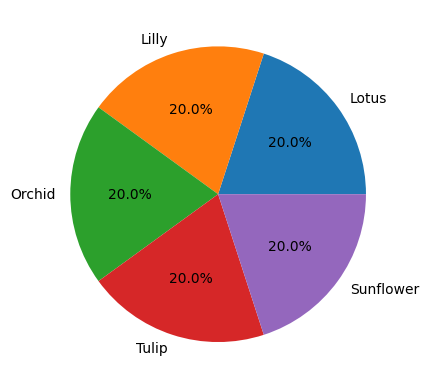

In [ ]:
plt.pie(df['labels'].value_counts(), labels=df['labels'].unique(), autopct='%1.1f%%')
plt.show()

# **DEFINE MODEL AND MODEL STRUCTURE:**

In [ ]:
image_shape = (image_size[0], image_size[1], 3)
class_count = len(df['labels'].unique())
print(class_count)
# EfficientNetB3 Setup
base_model_b = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=image_shape,
    pooling='max'
)

for i, layer in enumerate(base_model_b.layers):
    base_model_b.layers[i].trainable = False

model_b = Sequential([
    base_model_b,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
])

model_b.compile(Adamax(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_b.summary()

5
16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 4383912 (16.72 MB)
Trainable params: 331781 (1.27 MB)
Non-trainable params: 4052131 (15.46 MB)
____________

In [ ]:
checkpoint_path = "./cp.weights.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path ,
                                                save_weights_only= True,
                                                verbose = 1)

num_epochs = 15
his = model_b.fit(x = train_gen , validation_data = valid_gen , epochs = num_epochs , verbose = 1,
               validation_steps = None , shuffle = False , callbacks = [cp_callback])

Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 0.7241 - accuracy: 0.7333
Epoch 1: saving model to ./cp.weights.h5
250/250 [==============================] - 1239s 5s/step - loss: 0.7241 - accuracy: 0.7333 - val_loss: 0.3979 - val_accuracy: 0.8660
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.8380
Epoch 2: saving model to ./cp.weights.h5
250/250 [==============================] - 77s 307ms/step - loss: 0.4586 - accuracy: 0.8380 - val_loss: 0.3964 - val_accuracy: 0.8680
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8547
Epoch 3: saving model to ./cp.weights.h5
250/250 [==============================] - 79s 314ms/step - loss: 0.3897 - accuracy: 0.8547 - val_loss: 0.3037 - val_accuracy: 0.8880
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8798
Epoch 4: saving model to ./cp.weights.h5
250/250 [==============================] - 77s 307m

# **MODEL PERFORMANCE:**(Showing losses and accuracy through ghraphs)

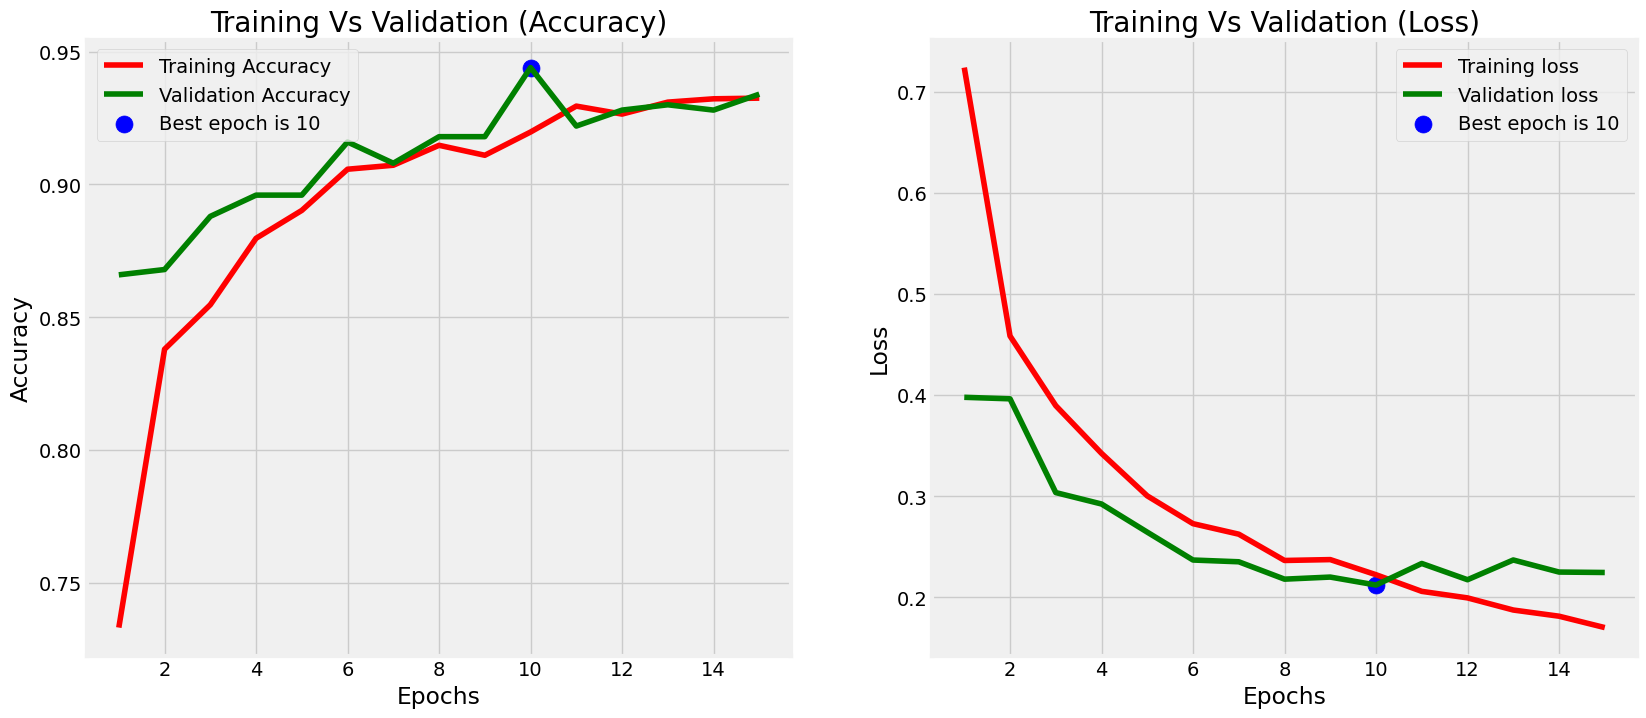

In [ ]:
train_acc = his.history['accuracy']
train_loss = his.history['loss']

val_acc = his.history['val_accuracy']
val_loss = his.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
acc_label = f'Best epoch is {str(index_acc +1)}'
loss_label = f'Best epoch is {str(index_loss +1)}'

plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc+1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title("Training Vs Validation (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , 'r' , label = "Training loss")
plt.plot(epochs , val_loss , 'g' , label = 'Validation loss')
plt.scatter(index_loss+1 , val_lowest , s = 150 , c= 'blue' , label = loss_label)
plt.title("Training Vs Validation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

# **MODEL  EVALUATION:**

In [ ]:
train_score = model_b.evaluate(train_gen , steps= 16 , verbose = 1)
val_score = model_b.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model_b.evaluate(test_gen , steps= 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", val_score[0])
print("Validation Accuracy: ", val_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 66s 4s/step - loss: 0.1845 - accuracy: 0.9453
Train Loss:  0.08153455704450607
Train Accuracy:  0.9765625
--------------------
Validation Loss:  0.2043944150209427
Validation Accuracy:  0.92578125
--------------------
Test Loss:  0.1844516396522522
Test Accuracy:  0.9453125


# **MODEL PREDICTION:**

In [ ]:
pred = model_b.predict(test_gen)
y_pred = np.argmax(pred, axis=1)


**CONFUSION METRICS**

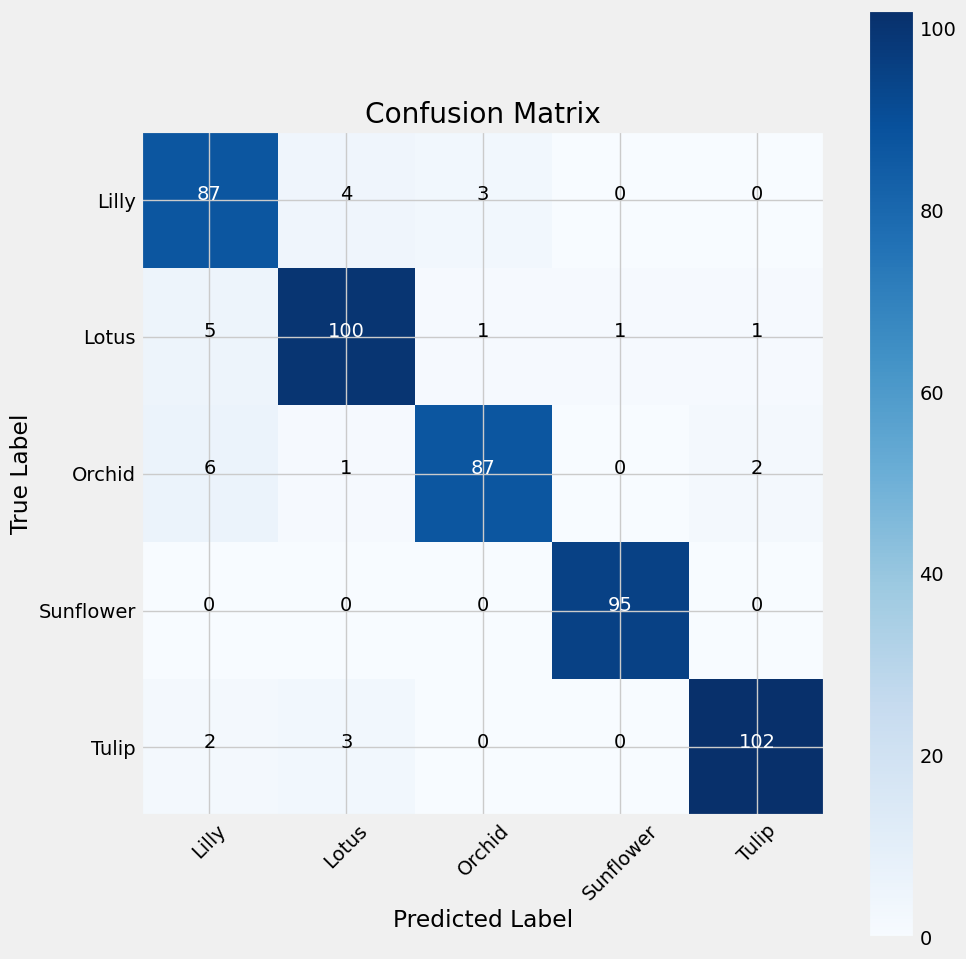

In [ ]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# **MODEL STRUCTURE without preTrained model:**

In [2]:
image_shape = (image_size[0], image_size[1], 3)
class_count = len(df['labels'].unique())
def create_cnn_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(5, activation='softmax'))
  return model

model = create_cnn_model()

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

NameError: name 'image_size' is not defined

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_filepath = '/content/best_mode.h5'  # Filepath where the best model weights will be saved
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
no_ephoc=50
history = model.fit(x = train_gen , steps_per_epoch= len(train_gen),validation_data = valid_gen , epochs = no_ephoc, verbose = 1,
               validation_steps = len(valid_gen), shuffle = False )


Epoch 1/50
125/125 [==============================] - 1695s 14s/step - loss: 1.2432 - accuracy: 0.4988 - val_loss: 1.7976 - val_accuracy: 0.2860
Epoch 2/50
125/125 [==============================] - 442s 4s/step - loss: 1.1221 - accuracy: 0.5540 - val_loss: 1.7610 - val_accuracy: 0.3660
Epoch 3/50
125/125 [==============================] - 446s 4s/step - loss: 1.0323 - accuracy: 0.5975 - val_loss: 1.6735 - val_accuracy: 0.2900
Epoch 4/50
125/125 [==============================] - 439s 4s/step - loss: 0.9603 - accuracy: 0.6212 - val_loss: 1.6392 - val_accuracy: 0.3560
Epoch 5/50
125/125 [==============================] - 430s 3s/step - loss: 0.9336 - accuracy: 0.6248 - val_loss: 0.9910 - val_accuracy: 0.6160
Epoch 6/50
125/125 [==============================] - 439s 4s/step - loss: 0.8673 - accuracy: 0.6710 - val_loss: 1.0163 - val_accuracy: 0.5940
Epoch 7/50
125/125 [==============================] - 428s 3s/step - loss: 0.8397 - accuracy: 0.6685 - val_loss: 1.0796 - val_accuracy: 0.56

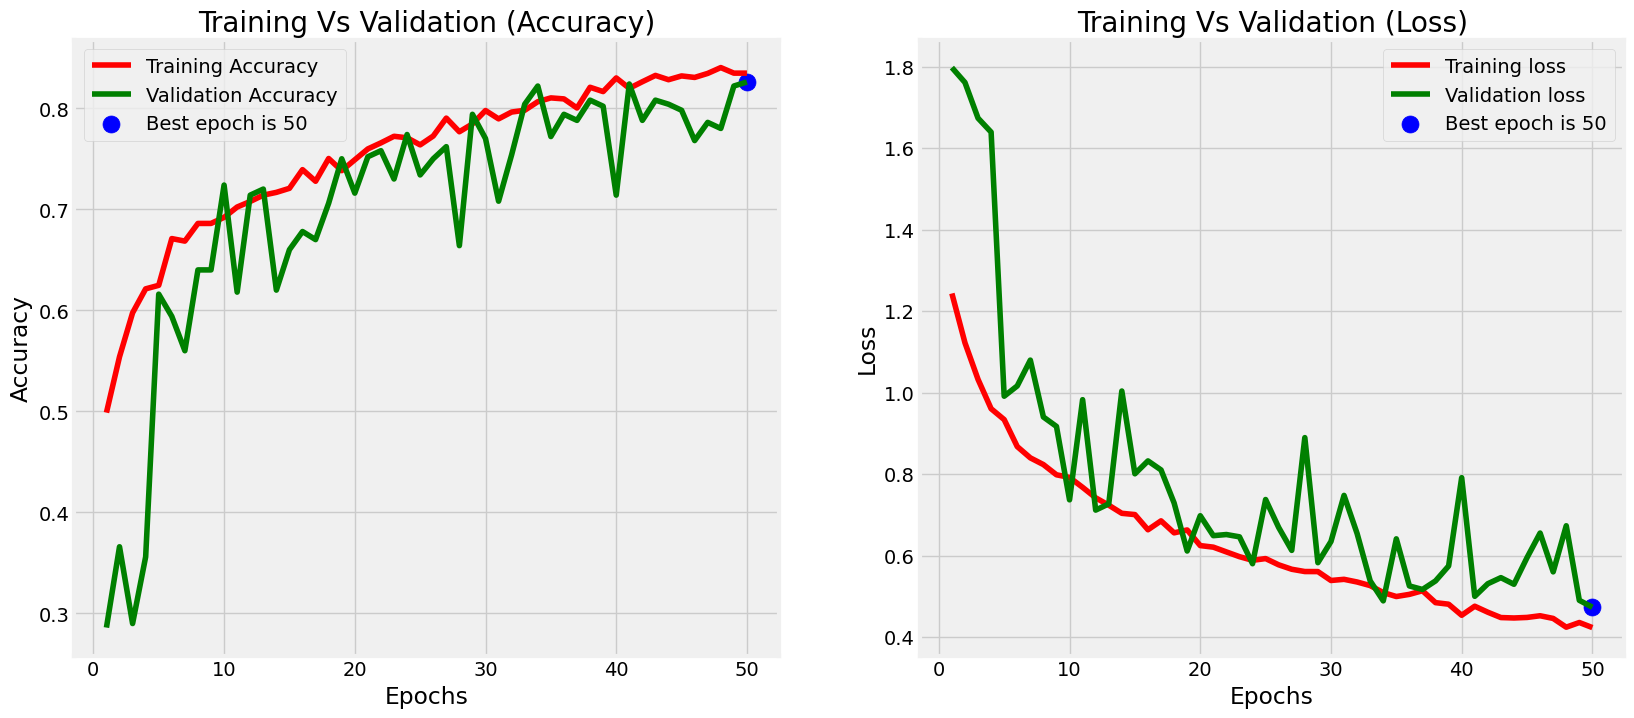

In [16]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
acc_label = f'Best epoch is {str(index_acc +1)}'
loss_label = f'Best epoch is {str(index_loss +1)}'

plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc+1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title("Training Vs Validation (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , 'r' , label = "Training loss")
plt.plot(epochs , val_loss , 'g' , label = 'Validation loss')
plt.scatter(index_loss+1 , val_lowest , s = 150 , c= 'blue' , label = loss_label)
plt.title("Training Vs Validation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

In [17]:
sec_pred = model.predict(test_gen)
sec_y_pred = np.argmax(sec_pred, axis=1)

16/16 [==============================] - 64s 4s/step


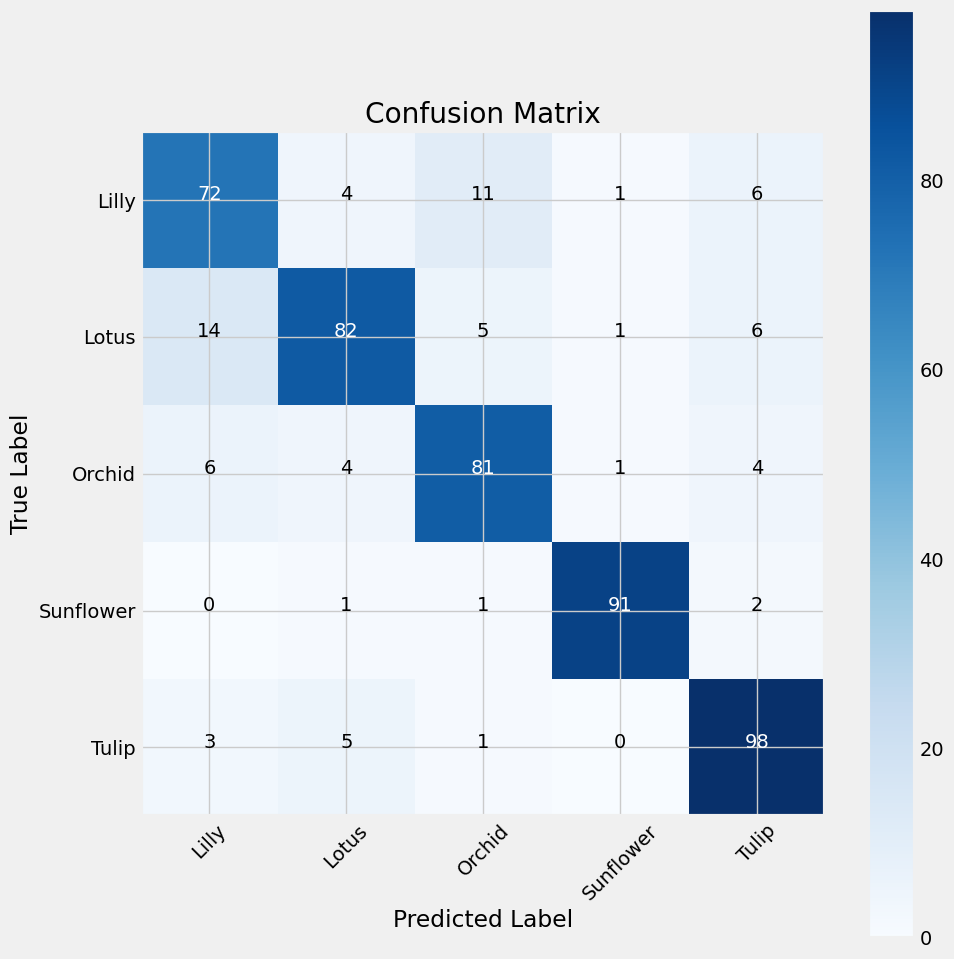

In [19]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, sec_y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()